In [110]:
from google.colab import files
files.upload()

In [111]:
!unzip '/content/Data.zip'

In [3]:
# importing libraries
import math
import pandas as pd
import numpy as np
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [4]:
order = pd.read_csv('Data/Assignment_Data.csv')
dp = pd.read_csv('Data/Delivery_Partners_Data.csv')

In [5]:
order.head()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
0,2745,180976,2021-02-13 03:08:24.000,2021-02-13 03:38:26.000,0,NaN,2021-02-13 03:01:11.686,2021-02-13 03:43:26.000,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34.000,373.0,37.377569,72.832560
1,9462,280243,2021-02-14 05:06:40.000,2021-02-14 05:31:04.000,0,NaN,2021-02-14 04:54:25.832,2021-02-14 05:36:04.000,516.8,342.5,451.0,3210.0,27,2021-02-14 05:06:40.000,373.0,37.380613,72.796909
2,14071,339813,2021-02-15 02:22:40.000,2021-02-15 02:44:02.000,0,NaN,2021-02-15 02:01:17.864,2021-02-15 02:49:02.000,459.5,418.7,443.0,2910.0,57,2021-02-15 02:22:35.000,373.0,37.372032,72.805871
3,14442,1315348,2021-02-15 03:01:25.000,2021-02-15 03:15:02.000,0,NaN,2021-02-15 02:43:41.129,2021-02-15 03:20:02.000,376.4,332.9,367.3,3210.0,41,2021-02-15 03:00:28.000,373.0,37.371380,72.819992
4,14515,1186729,2021-02-15 03:12:24.000,2021-02-15 03:50:24.000,0,NaN,2021-02-15 02:48:17.074,2021-02-15 03:55:24.000,414.5,334.1,413.2,3210.0,13,2021-02-15 03:12:09.000,373.0,37.369925,72.826764


In [6]:
order.sample(3)

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
126339,79324,893967,2021-02-26 03:14:33.000,2021-02-26 03:38:29.000,0,NaN,2021-02-26 03:00:59.452,2021-02-26 03:43:29.000,465.8,320.0,415.0,2260.0,57,2021-02-26 03:14:32.000,374.0,37.357929,72.861412
95454,110653,185363,2021-03-03 18:41:20.000,2021-03-03 19:02:57.000,0,NaN,2021-03-03 18:40:05.540,2021-03-03 19:07:57.000,367.7,340.4,341.8,1860.0,15,2021-03-03 18:40:52.000,372.0,37.392483,72.850318
42030,98316,1241381,2021-03-01 05:05:52.000,2021-03-01 05:08:52.000,1,Type-4,2021-03-01 05:04:26.008,2021-03-01 05:43:50.000,509.3,401.6,463.5,0.0,20,2021-03-01 05:05:15.000,668.0,37.400114,72.930197


In [7]:
order.shape

(132394, 17)

There are 132394 rows and 17 columns in the order assignment dataset

In [8]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132394 entries, 0 to 132393
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ORDER_ID                  132394 non-null  int64  
 1   DE_ID                     132394 non-null  int64  
 2   ASSIGNMENT_START_TIME     132394 non-null  object 
 3   ASSIGNMENT_END_TIME       132394 non-null  object 
 4   reject_ind                132394 non-null  int64  
 5   reject_type               8048 non-null    object 
 6   PLACED_TIME               132394 non-null  object 
 7   DELIVERED_TIME            131782 non-null  object 
 8   LASTMILE_DISTANCE         132384 non-null  float64
 9   FIRSTMILE_DISTANCE        132238 non-null  float64
 10  LAST_MILE_TIME_PREDICTED  132394 non-null  float64
 11  PAYOUT_MADE_TO_DE         132391 non-null  float64
 12  NUM_PING_COUNT_LAST10MIN  132394 non-null  int64  
 13  LAST_PING_TIME_LAST10MIN  132394 non-null  o

Null values in the columns of order assignment details dataset are present in reject_type, DELIVERED_TIME, LASTMILE_DISTANCE, PAYOUT_MADE_TO_DE, CUSTOMER_ZONE. 
The datatype of ASSIGNMENT_START_TIME, ASSIGNMENT_END_TIME, PLACED_TIME, DELIVERED_TIME are in string format which we need to convert into datetime format. The reject_type column is in categorical format therefore we need to encode that column.

In [9]:
order['CUSTOMER_ZONE'].unique()

array([373., 375., 668.,  nan, 841., 372., 382., 624., 374.])

In [10]:
len(order['CUSTOMER_ZONE'].unique())

9

In [11]:
len(order['DE_ID'].unique())

991

In total there are 991 delivery partners in Swiggy.

In [12]:
dp.sample(5)

,DE_ID,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID
306,271595,06:42,37.407032,72.878587,2020-05-10,624
583,378714,05:42,37.385059,72.862642,2020-08-29,624
535,362584,06:42,37.391476,72.849934,2020-08-14,372
728,324811,06:42,37.398369,72.926424,2020-07-06,668
363,310691,05:42,37.368085,72.840738,2020-06-21,374


In [13]:
dp.shape

(991, 6)

We have details about 991 delivery partners.

In [14]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DE_ID            991 non-null    int64  
 1   SHIFT_END_TIME   991 non-null    object 
 2   DE_HOME_LAT      991 non-null    float64
 3   DE_HOME_LNG      991 non-null    float64
 4   DE_JOINING_DATE  991 non-null    object 
 5   DE_ZONE_ID       991 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 46.6+ KB


There is no null values in the columns of delivery partner details dataset. The datatype of SHIFT_END_TIME, and DE_JOINING_DATE are in string format which we need to convert into datetime format. Rest all the column valuess are in numerical format.

In [15]:
dp['DE_ZONE_ID'].unique()

array([ 372,  375,  624,  668,  374,  841,  373, 1192])

In [16]:
order['reject_ind'].value_counts()

0    124346
1      8048
Name: reject_ind, dtype: int64

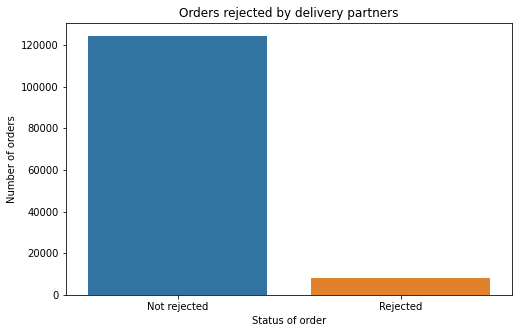

In [17]:
reject_ind_value_counts = dict(order['reject_ind'].value_counts())
status = ['Not rejected', 'Rejected']
values = list(reject_ind_value_counts.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
sns.barplot(x=status, y=values)

plt.xlabel("Status of order")
plt.ylabel("Number of orders")
plt.title("Orders rejected by delivery partners")
plt.show()

From the above graph we can see that, the number of orders that are accepted(1) is around 124346, and the number of orders that are rejected(0) is around 8048

In [18]:
order['reject_type'].value_counts()

Type-1    3853
Type-2    2007
Type-3    1449
Type-4     739
Name: reject_type, dtype: int64

In [23]:
len(order)-len(order['ORDER_ID'].unique())

7596

There are 7596 duplicate order IDs

In [24]:
order['ORDER_ID'].value_counts()[:10]

9795      13
37503     11
59285      8
94836      7
10893      7
43371      7
1750       6
43225      6
102097     6
2119       6
Name: ORDER_ID, dtype: int64

We can see that ORDER_ID 9795 has 13 occurences. Let's look at it closely to know the reason vbehind it.

In [25]:
order.loc[order['ORDER_ID']==9795]

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
54744,9795,1161842,2021-02-14 07:00:39.000,2021-02-14 07:30:48.000,0,NaN,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,400.1,487.2,5310.0,8,2021-02-14 07:00:05.000,NaN,37.401954,72.792432
54745,9795,333840,2021-02-14 06:13:24.000,2021-02-14 06:45:44.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,424.1,487.2,0.0,36,2021-02-14 06:11:58.000,NaN,37.401954,72.792432
54746,9795,333840,2021-02-14 06:13:24.000,2021-02-14 06:45:44.975,1,Type-3,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,424.1,487.2,0.0,36,2021-02-14 06:11:58.000,NaN,37.401954,72.792432
54747,9795,978904,2021-02-14 06:46:24.000,2021-02-14 06:48:23.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,397.7,487.2,0.0,9,2021-02-14 06:46:24.000,NaN,37.401954,72.792432
54748,9795,953785,2021-02-14 06:48:24.000,2021-02-14 06:50:33.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,420.8,487.2,0.0,24,2021-02-14 06:48:07.000,NaN,37.401954,72.792432
54749,9795,953785,2021-02-14 06:48:24.000,2021-02-14 06:50:33.857,1,Type-3,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,420.8,487.2,0.0,24,2021-02-14 06:48:07.000,NaN,37.401954,72.792432
54750,9795,1167674,2021-02-14 05:36:40.000,2021-02-14 06:02:51.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,393.5,487.2,0.0,10,2021-02-14 05:36:36.000,NaN,37.401954,72.792432
54751,9795,1167674,2021-02-14 05:36:40.000,2021-02-14 06:02:51.922,1,Type-3,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,393.5,487.2,0.0,10,2021-02-14 05:36:36.000,NaN,37.401954,72.792432
54752,9795,1167674,2021-02-14 06:12:31.000,2021-02-14 06:13:10.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,393.5,487.2,0.0,10,2021-02-14 05:36:36.000,NaN,37.401954,72.792432
54753,9795,1167674,2021-02-14 06:50:42.000,2021-02-14 06:54:29.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,393.5,487.2,0.0,10,2021-02-14 05:36:36.000,NaN,37.401954,72.792432


In [26]:
order.loc[order['ORDER_ID']==9795]['DE_ID'].unique()

array([1161842,  333840,  978904,  953785, 1167674, 1297294])

This order was assigned to 6 delivery executives and five of them has rejected the order with multiple rejection types.

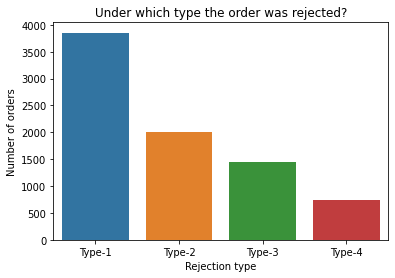

In [19]:
types = dict(order['reject_type'].value_counts())
sns.barplot(x=list(types.keys()), y=list(types.values()))

plt.xlabel("Rejection type")
plt.ylabel("Number of orders")
plt.title("Under which type the order was rejected?")
plt.show()

As we can see the rejected orders by delivery partners mostly fall under Type-I rejection. We need to find out what is the actual cause for delivery partners rejecting the orders.

**Left join two datasets on the basis of common DE_ID such that we can the delivery partner's information in the order assignment data itself**

In [20]:
total_df = pd.merge(left=order, right=dp, how='left', left_on='DE_ID', right_on='DE_ID')
total_df.sample(5)

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID
39984,90398,667718,2021-02-28 01:42:32.000,2021-02-28 02:11:44.000,0,NaN,2021-02-28 01:42:31.095,2021-02-28 02:16:44.000,325.1,395.9,326.5,1960.0,5,2021-02-28 01:41:55.000,375.0,37.408601,72.852451,06:42,37.412689,72.836534,2018-06-27,375
98697,65934,1299832,2021-02-24 03:40:53.000,2021-02-24 03:54:58.000,0,NaN,2021-02-24 03:33:43.999,2021-02-24 03:59:58.000,398.3,333.2,407.3,1960.0,14,2021-02-24 03:40:11.000,372.0,37.393515,72.850639,05:42,37.361231,72.878278,2019-05-26,372
8091,89982,339754,2021-02-28 00:36:32.000,2021-02-28 01:04:09.000,0,NaN,2021-02-28 00:35:39.142,2021-02-28 01:09:09.000,436.4,367.4,401.2,2510.0,12,2021-02-28 00:36:12.000,373.0,37.376160,72.814855,05:42,37.385567,72.865006,2020-07-25,372
59481,102065,286634,2021-03-02 03:15:36.000,2021-03-02 03:59:47.000,0,NaN,2021-03-02 03:05:11.564,2021-03-02 04:04:47.000,417.2,320.0,421.8,2760.0,17,2021-03-02 03:15:31.000,NaN,37.435975,72.870123,05:42,37.403414,72.891151,2020-05-25,624
15437,91016,375491,2021-02-28 02:46:33.000,2021-02-28 03:11:23.000,0,NaN,2021-02-28 02:37:49.374,2021-02-28 03:16:23.000,352.1,320.0,346.5,2760.0,12,2021-02-28 02:46:24.000,375.0,37.407799,72.857631,06:42,37.407914,72.850805,2020-08-25,375


In [27]:
total_df.shape

(132394, 22)

The number of rows remain same as it was there previously in order assignment deetails dataset, just that we have added the details of delivery partner in the next columns. Previously there were 17 columns, now it's 22.

In [28]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132394 entries, 0 to 132393
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ORDER_ID                  132394 non-null  int64  
 1   DE_ID                     132394 non-null  int64  
 2   ASSIGNMENT_START_TIME     132394 non-null  object 
 3   ASSIGNMENT_END_TIME       132394 non-null  object 
 4   reject_ind                132394 non-null  int64  
 5   reject_type               8048 non-null    object 
 6   PLACED_TIME               132394 non-null  object 
 7   DELIVERED_TIME            131782 non-null  object 
 8   LASTMILE_DISTANCE         132384 non-null  float64
 9   FIRSTMILE_DISTANCE        132238 non-null  float64
 10  LAST_MILE_TIME_PREDICTED  132394 non-null  float64
 11  PAYOUT_MADE_TO_DE         132391 non-null  float64
 12  NUM_PING_COUNT_LAST10MIN  132394 non-null  int64  
 13  LAST_PING_TIME_LAST10MIN  132394 non-null  o

The data is almost same as it was in order assignment details dataset, there was only addition in delivery partner details and we can see that there are no null values from delivery partner details dataset.

**Feature engineering of datetime data**

In [29]:
total_df['ASSIGNMENT_START_TIME'] = pd.to_datetime(total_df['ASSIGNMENT_START_TIME'], errors = 'coerce')
shift_end = pd.to_datetime(total_df['SHIFT_END_TIME'], errors = 'coerce')
joining = pd.to_datetime(total_df['DE_JOINING_DATE'], errors = 'coerce')

In [30]:
total_df['ASSIGNMENT_START_TIME'].isnull().sum()

0

There is no null values in ASSIGNMENT_START_TIME column

In [31]:
total_df['ASSIGNMENT_START_TIME'].head()

0   2021-02-13 03:08:24
1   2021-02-14 05:06:40
2   2021-02-15 02:22:40
3   2021-02-15 03:01:25
4   2021-02-15 03:12:24
Name: ASSIGNMENT_START_TIME, dtype: datetime64[ns]

Now, we can see that the data type is converted to datetime.

In [32]:
total_df['ASSIGNMENT_START_TIME_date'] = total_df['ASSIGNMENT_START_TIME'].dt.date
total_df['ASSIGNMENT_START_TIME_time'] = total_df['ASSIGNMENT_START_TIME'].dt.time
total_df['ASSIGNMENT_START_TIME_year'] = total_df['ASSIGNMENT_START_TIME'].dt.year
total_df['ASSIGNMENT_START_TIME_month'] = total_df['ASSIGNMENT_START_TIME'].dt.month
total_df['ASSIGNMENT_START_TIME_day'] = total_df['ASSIGNMENT_START_TIME'].dt.day
total_df['ASSIGNMENT_START_TIME_hour'] = total_df['ASSIGNMENT_START_TIME'].dt.hour
total_df['ASSIGNMENT_START_TIME_minute'] = total_df['ASSIGNMENT_START_TIME'].dt.minute
total_df['ASSIGNMENT_START_TIME_dayofweek'] = total_df['ASSIGNMENT_START_TIME'].dt.dayofweek

total_df['SHIFT_END_TIME'] = shift_end.dt.time
total_df['SHIFT_END_TIME_hour'] = shift_end.dt.hour
total_df['SHIFT_END_TIME_min'] = shift_end.dt.minute

total_df['DE_JOINING_DATE'] = joining.dt.date
total_df['DE_JOINING_DATE_year'] = joining.dt.year
total_df['DE_JOINING_DATE_month'] = joining.dt.month
total_df['DE_JOINING_DATE_day'] = joining.dt.day

Now, we will create two more features - difference between joining date and assignment of order date in months, difference between shift time and assignment of order time in hours

In [33]:
total_df['diff_joining_assign'] = (((total_df['ASSIGNMENT_START_TIME_date']-total_df['DE_JOINING_DATE']).dt.days)/30).astype(int)
total_df['diff_shift_assign'] = (total_df['SHIFT_END_TIME_hour']-total_df['ASSIGNMENT_START_TIME_hour'])

In [34]:
total_df['zone_diff'] = (abs(total_df['CUSTOMER_ZONE']-total_df['DE_ZONE_ID']))

In [35]:
total_df.loc[:, 'zone_diff'].value_counts()

0.0      55593
1.0      10887
3.0       9369
2.0       8039
249.0     5522
469.0     4225
252.0     3483
467.0     3465
44.0      2777
217.0     2699
466.0     1532
173.0     1417
250.0     1184
296.0      931
293.0      779
251.0      676
468.0      670
294.0      415
568.0       75
295.0       44
817.0       23
524.0       13
820.0       10
351.0        6
286.0        6
819.0        6
818.0        3
459.0        2
8.0          1
10.0         1
Name: zone_diff, dtype: int64

In [36]:
total_df.loc[total_df['reject_ind']==0, 'zone_diff'].value_counts().index[:10]

Float64Index([0.0, 1.0, 3.0, 2.0, 249.0, 469.0, 252.0, 467.0, 44.0, 217.0], dtype='float64')

In [37]:
total_df.loc[total_df['reject_ind']==1, 'zone_diff'].value_counts().index[:10]

Float64Index([0.0, 1.0, 3.0, 2.0, 249.0, 44.0, 252.0, 467.0, 217.0, 469.0], dtype='float64')

Therefore we can see that if the zone difference between the delivery executive and the customer zone is around 0-4 then those delivery partners are assigned more orders in this range of zone difference. Also, if the zone difference is too high, delivery partners don't opt for those assigned orders.

In [38]:
total_df['SHIFT_END_TIME'].unique()

array([datetime.time(5, 42), datetime.time(6, 42), datetime.time(1, 42),
       datetime.time(11, 42), datetime.time(8, 42), datetime.time(0, 42)],
      dtype=object)

From the above observation we can see that the shift end time are 6 unique values and as we know that in Swiggy the shift time of a delivery executive starts at 8 am and the delivery system at max continues till 12 am, so we can safely assume that the above timings given are in 12 hr format and all the shift timings end after 12 pm in a day. therefor we will change the time format to 24 hr format. Therefore adding 12 hrs to each of the above time and and 24 to 00 hr.

In [39]:
def shift_hours_add(hour):
  if hour == 0:
    hour = 24
  else:
    hour += 12
  return hour

# Converting SHIFT_END_TIME_hour to 24 hrs format
total_df['SHIFT_END_TIME_hour'] = total_df['SHIFT_END_TIME_hour'].apply(lambda x: shift_hours_add(x))


In [40]:
total_df['SHIFT_END_TIME_hour'].unique()

array([17, 18, 13, 23, 20, 24])

In [42]:
df_reject = total_df.loc[total_df['reject_ind']==1]
# (total_df['ASSIGNMENT_START_TIME_hour']-total_df['SHIFT_END_TIME_hour']).unique()
df_reject['diff_shift_assign'] = (df_reject['SHIFT_END_TIME_hour']-df_reject['ASSIGNMENT_START_TIME_hour'])

In [43]:
df_reject.loc[df_reject['ASSIGNMENT_START_TIME_hour']<=5].head()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID,ASSIGNMENT_START_TIME_date,ASSIGNMENT_START_TIME_time,ASSIGNMENT_START_TIME_year,ASSIGNMENT_START_TIME_month,ASSIGNMENT_START_TIME_day,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_minute,ASSIGNMENT_START_TIME_dayofweek,SHIFT_END_TIME_hour,SHIFT_END_TIME_min,DE_JOINING_DATE_year,DE_JOINING_DATE_month,DE_JOINING_DATE_day,diff_joining_assign,diff_shift_assign,zone_diff
38,67253,1186729,2021-02-24 05:14:34,2021-02-24 05:17:33.000,1,Type-2,2021-02-24 05:04:31.363,2021-02-24 05:38:00.000,397.1,447.8,376.5,0.0,9,2021-02-24 05:14:19.000,373.0,37.376211,72.829547,05:42:00,37.386463,72.854589,2019-04-05,372,2021-02-24,05:14:34,2021,2,24,5,14,2,17,42,2019,4,5,23,12,1.0
44,81535,1339906,2021-02-26 05:26:33,2021-02-26 05:30:30.000,1,Type-1,2021-02-26 05:21:48.465,2021-02-26 05:59:32.000,512.9,336.8,417.0,0.0,65,2021-02-26 05:26:18.000,373.0,37.376206,72.814922,06:42:00,37.407575,72.822828,2019-06-11,375,2021-02-26,05:26:33,2021,2,26,5,26,4,18,42,2019,6,11,20,13,2.0
47,86851,263776,2021-02-27 05:32:33,2021-02-27 05:35:33.000,1,Type-4,2021-02-27 05:25:10.639,2021-02-27 06:03:22.000,527.3,405.5,410.8,0.0,16,2021-02-27 05:31:27.000,373.0,37.375672,72.800895,06:42:00,37.425862,72.831065,2020-05-03,375,2021-02-27,05:32:33,2021,2,27,5,32,5,18,42,2020,5,3,10,13,2.0
56,101742,392348,2021-03-02 02:39:20,2021-03-02 02:42:20.000,1,Type-2,2021-03-02 02:32:47.165,2021-03-02 03:32:32.000,556.1,436.7,486.7,0.0,5,2021-03-02 02:31:43.000,373.0,37.376254,72.806285,06:42:00,37.415991,72.831829,2020-09-12,375,2021-03-02,02:39:20,2021,3,2,2,39,1,18,42,2020,9,12,5,16,2.0
103,49534,379318,2021-02-21 03:58:03,2021-02-21 03:58:28.000,1,Type-1,2021-02-21 03:51:40.965,2021-02-21 04:44:49.000,419.3,380.6,399.2,0.0,2,2021-02-21 03:57:47.000,373.0,37.375656,72.828943,06:42:00,37.413824,72.846072,2020-08-30,375,2021-02-21,03:58:03,2021,2,21,3,58,6,18,42,2020,8,30,5,15,2.0


In [44]:
df_reject['SHIFT_END_TIME_hour'].value_counts()

17    3253
18    2560
13     945
20     634
23     497
24     159
Name: SHIFT_END_TIME_hour, dtype: int64

Most of the delivery partners whose shift time ends at 5-6pm tends to reject assigned order.

In [45]:
df_reject['diff_joining_assign'].unique()

array([  28,   23,   20,   10,    5,   33,   32,    6,   25,   26,   22,
          9,    7,   15,   21,   17,   27,   30,   31,   34,   29,   16,
          8,   11,   19,   18,   12,   24, -243,    4,   14])

In [46]:
df_reject['diff_joining_assign'].value_counts()[:10]

6     1262
5     1065
9      776
7      500
23     493
22     492
27     409
26     377
10     308
21     298
Name: diff_joining_assign, dtype: int64

In [47]:
total_df['diff_joining_assign'].value_counts()[:10]

6     20743
5     15519
9     10245
22    10152
7      9045
27     7075
23     6776
26     6250
21     5527
10     5356
Name: diff_joining_assign, dtype: int64

In [48]:
df_3 = total_df.groupby('diff_joining_assign').filter(lambda x: len(x) > 5300)

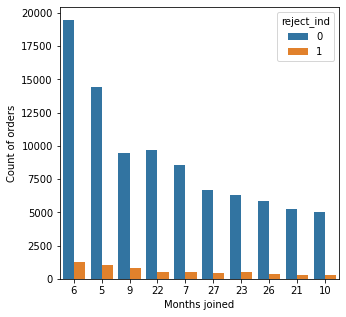

In [49]:
fig = plt.figure(figsize = (5, 5))
sns.countplot(data = df_3,
            x = 'diff_joining_assign',
            hue = 'reject_ind',
            order = df_3['diff_joining_assign'].value_counts().index)

plt.xlabel("Months joined")
plt.ylabel("Count of orders")
plt.show()

We can see that a delivery executive who has joined recently in the last 5-6 months tends to take more orders and these DE also rejects the most number of assigned orders

In [50]:
total_df.loc[total_df['reject_ind']==1].groupby('ASSIGNMENT_START_TIME_dayofweek').size()

ASSIGNMENT_START_TIME_dayofweek
0    1005
1    1102
2    1197
3    1260
4    1190
5    1129
6    1165
dtype: int64

The data is balanced here that means which day of week the order is assigned doesn't affect much the reject in assignmens by delivery partner. 

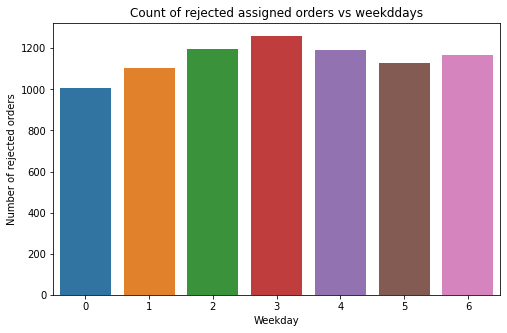

In [51]:
dict1 = dict(total_df.loc[total_df['reject_ind']==1].groupby('ASSIGNMENT_START_TIME_dayofweek').size())
fig = plt.figure(figsize = (8, 5))

sns.barplot(x=list(dict1.keys()), y=list(dict1.values()))

plt.xlabel("Weekday")
plt.ylabel("Number of rejected orders")
plt.title("Count of rejected assigned orders vs weekddays")
plt.show()

Here we can see that maximum rejected assigned orders happen on Thursday whereas least occurs on SUnday.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


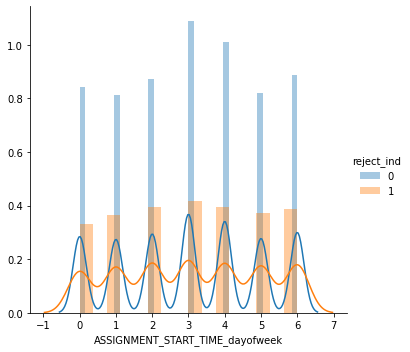

In [52]:
sns.FacetGrid(total_df, hue='reject_ind', size=5).map(sns.distplot, 'ASSIGNMENT_START_TIME_dayofweek').add_legend()
plt.show()

Here from the distribution plot the distribution of rejected assigned orders seems balanced. Maximum number of rejection of assigned orders we have seen previously during Thursday because there are maximum number of total orders on Thursday.

In [54]:
total_df.sample(3)

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID,ASSIGNMENT_START_TIME_date,ASSIGNMENT_START_TIME_time,ASSIGNMENT_START_TIME_year,ASSIGNMENT_START_TIME_month,ASSIGNMENT_START_TIME_day,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_minute,ASSIGNMENT_START_TIME_dayofweek,SHIFT_END_TIME_hour,SHIFT_END_TIME_min,DE_JOINING_DATE_year,DE_JOINING_DATE_month,DE_JOINING_DATE_day,diff_joining_assign,diff_shift_assign,zone_diff
97023,120986,122229,2021-03-05 02:32:04,2021-03-05 03:05:55.000,0,NaN,2021-03-05 02:25:33.412,2021-03-05 03:10:55.000,344.9,419.3,324.3,2260.0,39,2021-03-05 02:31:52.000,372.0,37.384954,72.846530,05:42:00,37.391511,72.858363,2019-09-02,372,2021-03-05,02:32:04,2021,3,5,2,32,4,17,42,2019,9,2,18,3,0.0
19571,10029,908998,2021-02-14 05:56:24,2021-02-14 06:21:25.000,0,NaN,2021-02-14 05:53:21.481,2021-02-14 06:26:25.000,424.7,369.8,399.2,2760.0,48,2021-02-14 05:55:49.000,375.0,37.402871,72.832625,11:42:00,37.428683,72.848385,2018-11-19,372,2021-02-14,05:56:24,2021,2,14,5,56,6,23,42,2018,11,19,27,6,3.0
98554,12312,1249476,2021-02-14 22:48:40,2021-02-14 23:05:10.000,0,NaN,2021-02-14 22:25:40.136,2021-02-14 23:10:10.000,408.2,339.5,362.2,2960.0,3,2021-02-14 22:47:57.000,372.0,37.388261,72.863325,11:42:00,37.382760,72.873082,2019-05-04,372,2021-02-14,22:48:40,2021,2,14,22,48,6,23,42,2019,5,4,21,-11,0.0


In [55]:
total_df['ASSIGNMENT_START_TIME'].dt.year.unique()

array([2021])

In [56]:
total_df['ASSIGNMENT_START_TIME_hour'].unique()

array([ 3,  5,  2,  4, 18,  1,  7, 10, 22,  6, 19, 20, 23, 21,  9,  0, 17,
        8, 16, 11, 15, 14, 12])

In [57]:
total_df['ASSIGNMENT_START_TIME_month'].unique()

array([2, 3])

We have data of the month of February and March of year 2021

In [58]:
total_df['ASSIGNMENT_START_TIME_dayofweek'].unique()

array([5, 6, 0, 1, 2, 3, 4])

In [59]:
total_df.sort_values(by='ASSIGNMENT_START_TIME_date').groupby(['DE_ID', 'ASSIGNMENT_START_TIME_date']).cumcount()

29959      0
67183      0
67184      0
14177      0
14178      0
          ..
96084      3
96085     11
96086     14
95767     12
132393     9
Length: 132394, dtype: int64

In [67]:
# importing sklearn and its modules
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import feature_extraction, preprocessing, model_selection, linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import decomposition, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [60]:
df = total_df[['LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE', 'LAST_MILE_TIME_PREDICTED', 'CUSTOMER_LAT',
       'CUSTOMER_LNG', 'DE_HOME_LAT', 'DE_HOME_LNG','ASSIGNMENT_START_TIME_year',
       'ASSIGNMENT_START_TIME_hour', 'ASSIGNMENT_START_TIME_dayofweek', 'SHIFT_END_TIME_hour', 'DE_JOINING_DATE_year', 'diff_joining_assign', 'reject_ind']]
df.isnull().sum()

LASTMILE_DISTANCE                   10
FIRSTMILE_DISTANCE                 156
LAST_MILE_TIME_PREDICTED             0
CUSTOMER_LAT                         0
CUSTOMER_LNG                         0
DE_HOME_LAT                          0
DE_HOME_LNG                          0
ASSIGNMENT_START_TIME_year           0
ASSIGNMENT_START_TIME_hour           0
ASSIGNMENT_START_TIME_dayofweek      0
SHIFT_END_TIME_hour                  0
DE_JOINING_DATE_year                 0
diff_joining_assign                  0
reject_ind                           0
dtype: int64

In [61]:
df.loc[df['reject_ind']==1].isnull().sum()

LASTMILE_DISTANCE                   7
FIRSTMILE_DISTANCE                 37
LAST_MILE_TIME_PREDICTED            0
CUSTOMER_LAT                        0
CUSTOMER_LNG                        0
DE_HOME_LAT                         0
DE_HOME_LNG                         0
ASSIGNMENT_START_TIME_year          0
ASSIGNMENT_START_TIME_hour          0
ASSIGNMENT_START_TIME_dayofweek     0
SHIFT_END_TIME_hour                 0
DE_JOINING_DATE_year                0
diff_joining_assign                 0
reject_ind                          0
dtype: int64

Only LASTMILE_DISTANCE and FIRSTMILE_DISTANCE have null values, and since the rows with reject_ind=1 are less therefore we plan to keep rows having missing values for rejected assigned orders.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


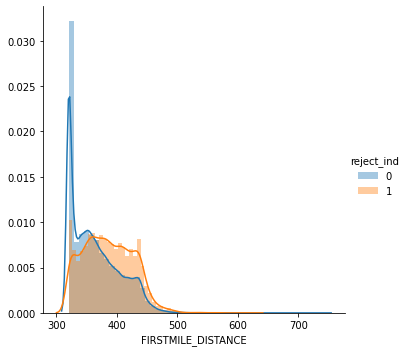

In [62]:
sns.FacetGrid(total_df, hue='reject_ind', size=5).map(sns.distplot, 'FIRSTMILE_DISTANCE').add_legend()
plt.show()

From the distribution plot we can see that as the first mile distance increases the number of assigned orders that are accepted becomes less, whereas if the first mile distance is in the range of 300 the chances of the order getting accepted by delivery excutive is high. Similary, we can see that the rejection rate is less when the first mile distance is within 300 miles.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


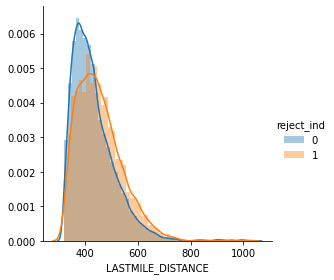

In [63]:
sns.FacetGrid(total_df, hue='reject_ind', size=4).map(sns.distplot, 'LASTMILE_DISTANCE').add_legend()
plt.show()

Last mile distance seems to have not much difference in distribution when compared with rejected assigned order vs accepted assigned order. But still we can observe that last mile distance within 400 has high percentage of offers that are accepted.

In [64]:
# Dropping rows having missing values
df_2 = df.dropna()

In [65]:
X = (df_2.iloc[:, :-1]).values
y = (df_2['reject_ind']).values

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=0.5)

**USING LOGISTIC REGRESSION MODEL ON OUR DATA**

In [69]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_train_log_pred = logreg.predict(x_train)
y_val_log_pred = logreg.predict(x_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [70]:
accuracy_score(y_train, y_train_log_pred)

0.9393385596531472

In [71]:
accuracy_score(y_val, y_val_log_pred)

0.9393905021173624

In [72]:
print(classification_report(y_val, y_val_log_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     24846
           1       0.33      0.00      0.00      1602

    accuracy                           0.94     26448
   macro avg       0.64      0.50      0.48     26448
weighted avg       0.90      0.94      0.91     26448



Our logistic regression model was not able to capture the relation of minority class. We didn't use class weights here and also didn't do downsampling or upsampling because of possible loss of information.

**Filling missing values with median (for reject_ind==1)**

In [73]:
df.shape

(132394, 14)

In [74]:
# Find median of firstmile distance and lastmile distance when reject_ind==1
firstmile_median = df.loc[df['reject_ind']==1]['FIRSTMILE_DISTANCE'].median(axis=0)
print("Median of FIRSTMILE_DISTANCE with reject_ind==1: ", firstmile_median)
lastmile_median = df.loc[df['reject_ind']==1]['LASTMILE_DISTANCE'].median(axis=0)
print("Median of LASTMILE_DISTANCE with reject_ind==1: ", lastmile_median)

Median of FIRSTMILE_DISTANCE with reject_ind==1:  383.3
Median of LASTMILE_DISTANCE with reject_ind==1:  441.2


In [78]:
df.drop(df[(df['reject_ind']==0) & (df['FIRSTMILE_DISTANCE'].isnull())].index, inplace=True)
df.drop(df[(df['reject_ind']==0) & (df['LASTMILE_DISTANCE'].isnull())].index, inplace=True)

In [79]:
df.shape

(132275, 14)

119 rows were deleted since 119 rows with accpeted assigned order had null values in their FIRSTMILE_DISTANCE and LASTMILE_DIASTANCE

In [80]:
# filling a null values using fillna() and median values that we have calculated
df['FIRSTMILE_DISTANCE'].fillna(firstmile_median, inplace = True)
df['LASTMILE_DISTANCE'].fillna(lastmile_median, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [81]:
df.isnull().sum()

LASTMILE_DISTANCE                  0
FIRSTMILE_DISTANCE                 0
LAST_MILE_TIME_PREDICTED           0
CUSTOMER_LAT                       0
CUSTOMER_LNG                       0
DE_HOME_LAT                        0
DE_HOME_LNG                        0
ASSIGNMENT_START_TIME_year         0
ASSIGNMENT_START_TIME_hour         0
ASSIGNMENT_START_TIME_dayofweek    0
SHIFT_END_TIME_hour                0
DE_JOINING_DATE_year               0
diff_joining_assign                0
reject_ind                         0
dtype: int64

Now we can see that there are no null values.

In [82]:
X = (df.iloc[:, :-1]).values
y = (df['reject_ind']).values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=0.5)

**USING RANDOM FOREST ON OUR DATA**

In [83]:
rf=RandomForestClassifier(max_depth = 5, n_estimators=100)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [84]:
y_train_preds = rf.predict(x_train)
y_val_preds = rf.predict(x_val)

In [85]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     24846
           1       0.00      0.00      0.00      1609

    accuracy                           0.94     26455
   macro avg       0.47      0.50      0.48     26455
weighted avg       0.88      0.94      0.91     26455



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our model still is unable to cpature the realtion of minority class, we didn't give weights to the target classes yet.

**Creating a distance feature with the use of latitude and longitude of customer address and delivery executive home address. This feature will give the distance between customer's address and DE's home address**

In [86]:
from math import radians, cos, sin, asin, sqrt
def distance(dataframe):
  lat1, lat2, lon1, lon2 = dataframe['CUSTOMER_LAT'], dataframe['DE_HOME_LAT'], dataframe['CUSTOMER_LNG'], dataframe['DE_HOME_LNG']
  # The math module contains a function named radians which converts from degrees to radians.
  lon1 = radians(lon1)
  lon2 = radians(lon2)
  lat1 = radians(lat1)
  lat2 = radians(lat2)
  # Haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * asin(sqrt(a))
  # Radius of earth in kilometers. Use 3956 for miles
  r = 6371 
  # calculate the result
  return (c*r)

In [88]:
df['distance'] = df.apply(distance, axis=1)

In [89]:
df['distance'].describe()

count    132275.000000
mean          6.229438
std          52.909534
min           0.003331
25%           1.787352
50%           3.078555
75%           4.824250
max        1363.208516
Name: distance, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


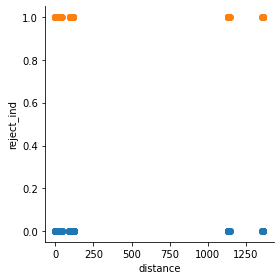

In [90]:
sns.FacetGrid(df, hue='reject_ind', size=4).map(plt.scatter, 'distance', 'reject_ind')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


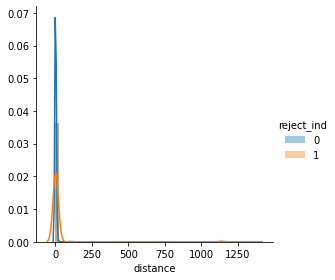

In [91]:
sns.FacetGrid(df, hue='reject_ind', size=4).map(sns.distplot, 'distance').add_legend()
plt.show()

Therefore we can see that distance between DE home address and customer address when less the DE accepts more order.

In [92]:
df = df[['LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE', 'LAST_MILE_TIME_PREDICTED', 'distance',
       'ASSIGNMENT_START_TIME_year', 'ASSIGNMENT_START_TIME_hour', 'ASSIGNMENT_START_TIME_dayofweek', 'SHIFT_END_TIME_hour',
       'DE_JOINING_DATE_year', 'reject_ind']]

In [93]:
X = (df.iloc[:, :-1]).values
y = (df['reject_ind']).values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=0.5)

**RANDOM FOREST - using balanced class weights**

In [96]:
rf=RandomForestClassifier(max_depth = 5, n_estimators=100, class_weight='balanced')
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [97]:
y_train_preds = rf.predict(x_train)
y_val_preds = rf.predict(x_val)

In [98]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.97      0.57      0.72     24846
           1       0.09      0.69      0.17      1609

    accuracy                           0.58     26455
   macro avg       0.53      0.63      0.44     26455
weighted avg       0.91      0.58      0.68     26455



We can see improvement in our recall score as we have given class weights to our random forest model, whereas it has resulted in fall in our precision score for class 0. Precision score is 0.17 which is not good.

In [99]:
# define model
rf_2 = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')

In [100]:
rf_2.fit(x_train, y_train)
y_train_preds_ = rf_2.predict(x_train)
y_val_preds_ = rf_2.predict(x_val)
print(classification_report(y_val, y_val_preds_))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     24846
           1       0.92      0.17      0.28      1609

    accuracy                           0.95     26455
   macro avg       0.93      0.58      0.63     26455
weighted avg       0.95      0.95      0.93     26455



Using class weights as 'balanced subsample' the f1_score has increased from 0.17 to 0.28

Feature: 0, Score: 0.17258
Feature: 1, Score: 0.23975
Feature: 2, Score: 0.17495
Feature: 3, Score: 0.18828
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.07992
Feature: 6, Score: 0.07122
Feature: 7, Score: 0.04135
Feature: 8, Score: 0.03195


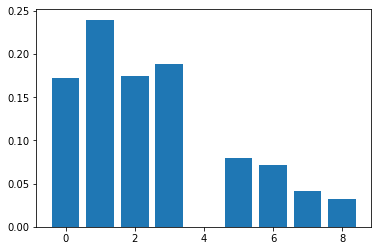

In [101]:
# get feature importance
importance = rf_2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [109]:
df.iloc[:, :-1].columns

Index(['LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE', 'LAST_MILE_TIME_PREDICTED',
       'distance', 'ASSIGNMENT_START_TIME_year', 'ASSIGNMENT_START_TIME_hour',
       'ASSIGNMENT_START_TIME_dayofweek', 'SHIFT_END_TIME_hour',
       'DE_JOINING_DATE_year'],
      dtype='object')

Therefore we can see that feature 4 i.e. ''ASSIGNMENT_START_TIME_year' distance doesn't help our model, feature 0 to 4 are important i.e 'LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE', 'LAST_MILE_TIME_PREDICTED', and 
       'distance'

I have chosen the f1_score as my evaluation metrics since it brings a balance between precision and recall, now recall is important for us because since it helps us maintain all the relevant instances in our data, so is our precision as it tells us how much our model is relevant. Giving class_weights to the model we have seen that the recall of our model for minority class increases whereas for majority class it deacreses with also precision_score being very little for minority class. Whereas if we 'balanced_subsample' as our class_weights then there is a balance between recall, precision - this we get using f1_score.

Further improvements in model: We can possibly use other techniques to handle the imbalanced nature of data classes. I didn't use undersampling of majority class because it may lead to losing data which is not preferred.

OBSERVATIONS:

1. The data is imbalanced heavily with class 0 having around 120000 rows and class 1 having 8048 rows.

2. The end_shift_time of the delivery boy was not clear, the time was not in 24 hrs format neither it was mentioned whether the shift ends at am or pm. Assuming that the shift starts at 8 am and end at 12 am, the time was chaned to 24 hrs format. We observed that when the DE gets order when his/her shift_end_time is near, the DE tends to reject the assigned order.

3. The first mile distance is an important feature when it comes to DE rejecting or accepting an offer. If it's too far, then DE rejects the order

4. After doing a lot of analysis on the data we understood when a delivery agent is new, he tends to deliver more orders as compared to someone who has been working for 2-3 years. Possibly since that person takes so many orders often the delivery executive assignment system assigns them more orders which sometimes lead to rejection of the order.

5. At a particlar shift of the day the surge in customers ordering food is high, and maybe due to excessive offers the DE get during that time the number of assigned orders rejected are more during that time. We can possibly make sure that during that partcular time we have maximum number of DE and not much DE's shifts end during that time. This will help us deal with huge customers during that time without disappointing them with much waiting time making better customer experience.

6. Using shift_end_time and assignment_order_time we can get the dead_hour of the DE and see if a DE rejects more orders during his/her dead hour. Dead hour is the hour in which the shift_end_time of the DE is near. From the patterns we can see which DE tend to reject more offer during their dead_hour.

7. In a day every DE must have limits and patterns in the number of orders they deliver. One DE might take 20 orders per day whereas another might take 10 orders at maximum. We can track how many orders in a day a DE is delivering, if they feels like they have exhausted one day's work then they might reject order after that.